In [2]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

db=mysql.connector.connect(host='localhost',
                          username='******',
                          password='******',
                          database='ecommerce')
curr=db.cursor()


#list all unique cities where customers are located.


In [2]:
query=''' select distinct customer_city
        from customers'''
curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data ,columns=['City'])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#count the no. of orders placed in 2017.

In [4]:
query='''select count(order_id)
from orders where year(order_purchase_timestamp)=2017'''
curr.execute(query)
data=curr.fetchall()
"Total orders placed in 2017 are",data[0][0]

('Total orders placed in 2017 are', 45101)

#find the total sales per category.

In [18]:
query=''' select products.product_category category, round(sum(payments.payment_value),2) sales
         from products join order_items
         on products.product_id=order_items.product_id
         join payments
         on payments.order_id=order_items.order_id
         group by category
      '''

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data , columns=['Category' ,'Sales'])
df


,Category,Sales
0,perfumery,523417.94
1,Furniture Decoration,1469485.44
2,telephony,512047.80
3,bed table bath,1777634.98
4,automotive,878272.55
...,...,...
69,cds music dvds,1274.37
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


#calculate the percentage of orders that were paid in installments.

In [27]:
query=''' select (sum( case when payment_installments>=1 then 1 else 0 end))/count(*)*100
          from payments
          '''

curr.execute(query)
data=curr.fetchall()
'the percentage of orders that were paid in installments are',data[0][0]

('the percentage of orders that were paid in installments are',
 Decimal('99.9981'))

#count the no. of customers from each state.

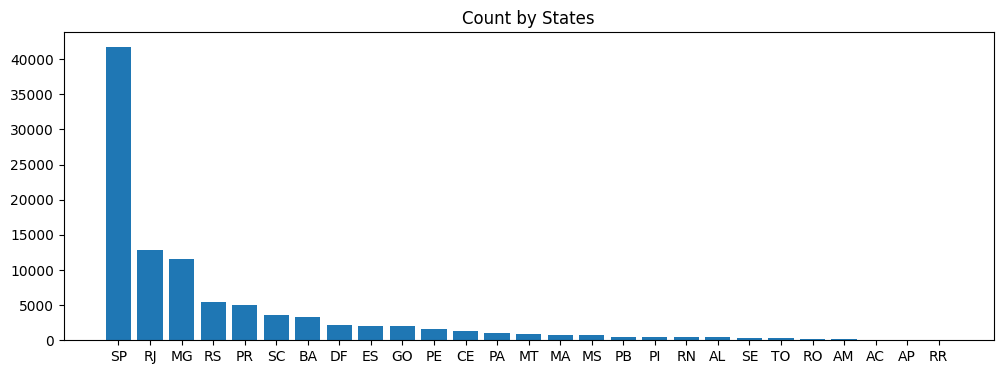

In [7]:
query=''' select customer_state ,count(distinct customer_id) from 
    customers
    group by customer_state'''

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data , columns=['State','Count'])
df=df.sort_values(by ='Count' ,ascending=False)

plt.figure(figsize=(12,4))
plt.title('Count by States')
plt.bar(df['State'] , df['Count'])
plt.show()

#calculate the no. of orders per month in 2018.

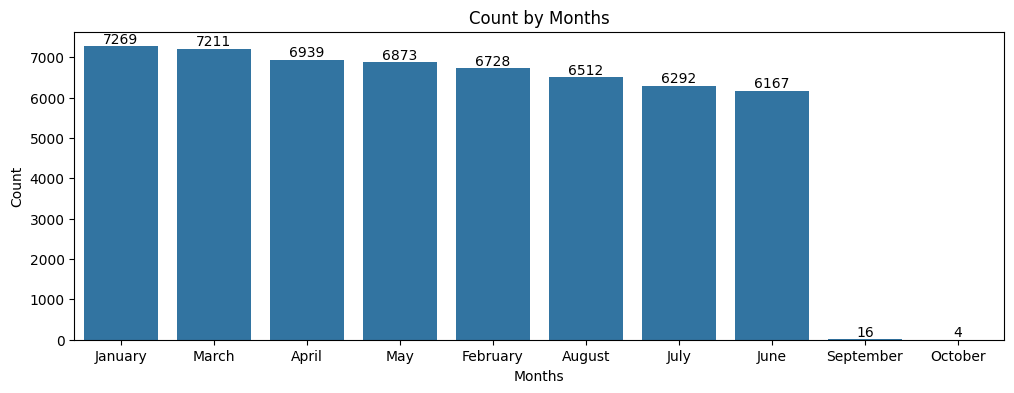

In [57]:
query=''' select monthname(order_purchase_timestamp) Months , count(order_id) Count
          from orders
          where year(order_purchase_timestamp)=2018
          group by monthname(order_purchase_timestamp)'''

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data , columns=['Months','Count'])
df

plt.figure(figsize=(12,4))
df=df.sort_values(by ='Count' ,ascending=False)
ax=sns.barplot(df,x=df['Months'] , y=df['Count'])
plt.title('Count by Months')
for bars in ax.containers:
    ax.bar_label(bars)


#find the avg. no. of products per order , grouped by customer city.

In [10]:
query=''' with count_per_order as(
           select orders.order_id , orders.customer_id , count(order_items.order_id) as oc
           from orders join order_items
           on orders.order_id=order_items.order_id
           group by orders.order_id , orders.customer_id)
           select customers.customer_city , round(avg(count_per_order.oc),2)average_orders
           from customers join count_per_order
           on customers.customer_id=count_per_order.customer_id
           group by customers.customer_city order by average_orders desc'''

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data , columns=['Customer_city','Average_orders/order'])
df.head(10)

,Customer_city,Average_orders/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


#cal the percentage of total revenue contributed by each product category.

In [29]:
query=''' select products.product_category category, 
round(sum(payments.payment_value)/(select sum(payment_value)from payments )*100 ,2)sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by products.product_category order by sales desc
'''

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data , columns=['Product Category' , 'Payment Perc.'])
df

,Product Category,Payment Perc.
0,bed table bath,11.10
1,HEALTH BEAUTY,10.62
2,computer accessories,10.29
3,Furniture Decoration,9.18
4,Watches present,9.14
...,...,...
69,House Comfort 2,0.01
70,cds music dvds,0.01
71,PC Gamer,0.01
72,Fashion Children's Clothing,0.00


#identify the correlation between product price and the no. of times the product has been purchased.

In [8]:
query=''' select products.product_category , count(order_items.product_id),
          round(avg(order_items.price),2)
          from products join order_items
          on products.product_id=order_items.product_id
          group by products.product_category'''

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data , columns=['Product Category' , 'Order Count' ,'Price'])
df
arr1=df['Order Count']
arr2=df['Price']
a=np.corrcoef([arr1,arr2])
a[0][1]
#as it is negative thus it is inversely proportional

np.float64(-0.10731569037851364)

#calculate the total revenue genrated by each seller and rank them by revnue.

In [19]:
query=''' select * ,dense_rank() over (order by rev desc) as rn
          from (select sellers.seller_id , round(sum(payments.payment_value),2) rev
          from sellers join order_items
          on sellers.seller_id=order_items.seller_id
          join payments 
          on order_items.order_id=payments.order_id
          group by sellers.seller_id ) as a'''

curr.execute(query)
data=curr.fetchall()
# data
df=pd.DataFrame(data , columns=['Seller' ,'Total Revenue','Rank'])
df

,Seller,Total Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,522960.21,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,320728.62,2
2,4a3ca9315b744ce9f8e9374361493884,310742.14,3
3,53243585a1d6dc2643021fd1853d8905,299656.66,4
4,1f50f920176fa81dab994f9023523100,295738.44,5
...,...,...,...
3090,3ac588cd562971392504a9e17130c40b,19.29,3075
3091,ad14615bdd492b01b0d97922e87cb87f,19.21,3076
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3077
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3078


#calculate the moving avg of order values for each customer over their order history.

In [24]:
query=''' select customer_id, order_purchase_timestamp , payment
          ,avg(payment) over (partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row)
          as mov_avg
          from 
          (select orders.customer_id ,orders.order_purchase_timestamp,
          payments.payment_value as payment
          from payments join orders
          on payments.order_id=orders.order_id) as a'''

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


#cal. the comulative sales per month for each year.

In [32]:
query='''  select yrs, months ,payment, sum(payment) over (order by yrs , months) Comulative_Sales from
          (select year(orders.order_purchase_timestamp) as yrs,
          month(orders.order_purchase_timestamp) as months,
          round(sum(payments.payment_value),2) as payment
          from orders join payments
          on orders.order_id=payments.order_id
          group by yrs , months order by yrs, months) as a
         '''

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=['years','Months','Payment','Comulative Payment'])
df

,years,Months,Payment,Comulative Payment
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


#cal. the year over year month rate of total sales.

In [38]:
query=''' with a as(select year(orders.order_purchase_timestamp) as yrs,
          round(sum(payments.payment_value),2) as payment
          from orders join payments
          on orders.order_id=payments.order_id
          group by yrs  order by yrs)
          select yrs, ((payment-lag(payment,1) over(order by yrs))/lag(payment,1) over(order by yrs))*100
          from a'''

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=['Years','YOY % Growth'])
df

,Years,YOY % Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


In [40]:
#identify the top 3 customers who spent the most money in each year.

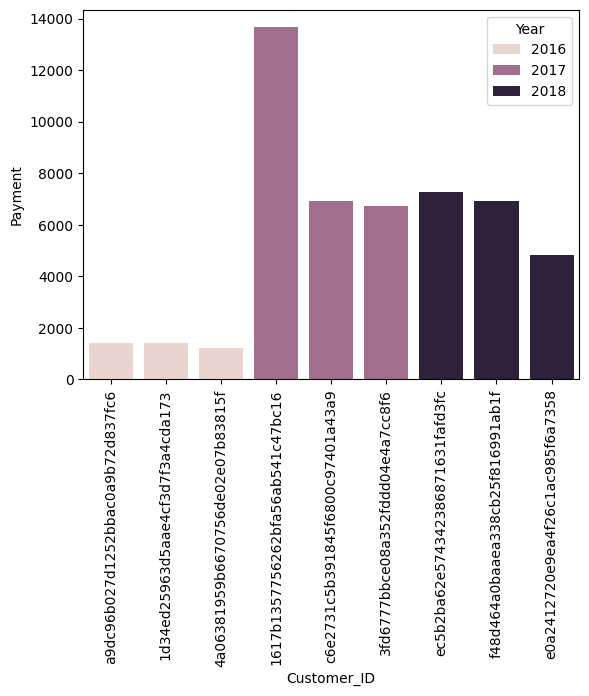

In [54]:
query=''' select years,customer_id,payment ,d_rank
          from
          (select year(orders.order_purchase_timestamp) years,
          orders.customer_id,
          round(sum(payments.payment_value),2) payment,
          dense_rank() over(partition by year(orders.order_purchase_timestamp)
          order by sum(payments.payment_value) desc) d_rank
          from orders join payments 
          on orders.order_id=payments.order_id
          group by year(orders.order_purchase_timestamp),
          orders.customer_id) as a
          where d_rank<=3'''

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=['Year','Customer_ID','Payment','Rank'])
df
sns.barplot(df,x="Customer_ID", y="Payment" , hue='Year')
plt.xticks(rotation=90)
plt.show()